In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Point
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
from pykrige.ok import OrdinaryKriging  # PyKrige import


In [36]:
file_path = "with LongLat_rainfall_trend_results.csv"

try:
    df = pd.read_csv(file_path)
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
except Exception as e:
    print(f"An error occurred: {e}")


In [37]:

# Convert Latitude and Longitude to Decimal Degrees for easy processing
df['lat_decimal'] = df['Lat (Deg)'] + df['Lat (Min)'] / 60
df['lon_decimal'] = df['Long (Deg)'] + df['Long (Min)'] / 60

# Load Bangladesh boundary from Natural Earth (50m resolution)
world = gpd.read_file("https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_countries.zip")
bangladesh_shp = world[world.NAME == "Bangladesh"]

# Create a polygon with a buffer for better edge coverage
bangladesh_polygon = bangladesh_shp.geometry.iloc[0].buffer(0.1)  # Small buffer of 0.1 degrees


In [38]:

# Define grid for interpolation
lon_min, lon_max = 88, 93   # Bangladesh Longitude range
lat_min, lat_max = 20.5, 26.5  # Bangladesh Latitude range
# Define grid for interpolation with lower resolution
grid_resolution = 10 # Reduced resolution (from 300 to 150)
grid_x, grid_y = np.meshgrid(
    np.linspace(lon_min, lon_max, grid_resolution),  # Adjust grid resolution
    np.linspace(lat_min, lat_max, grid_resolution)
)
# Create a custom colormap with darker red and blue shades
cmap = LinearSegmentedColormap.from_list("custom_cmap", ["darkred", "white", "darkblue"], N=256)

# Define a color intensity variable (you can adjust this value as needed)
color_intensity = 0.25  # Adjust this value to control color intensity: 1.0 = standard, >1.0 = more intense colors

# Normalize the data with scaling for color intensity control
max_value = np.max(np.abs(df.iloc[:, 6:].values))  # Find the maximum absolute rainfall value for normalization
norm = TwoSlopeNorm(vmin=-max_value * color_intensity, vcenter=0, vmax=max_value * color_intensity)  # Scale based on color_intensity


TypeError: Shapes of x (10, 10) and z (100, 100) do not match

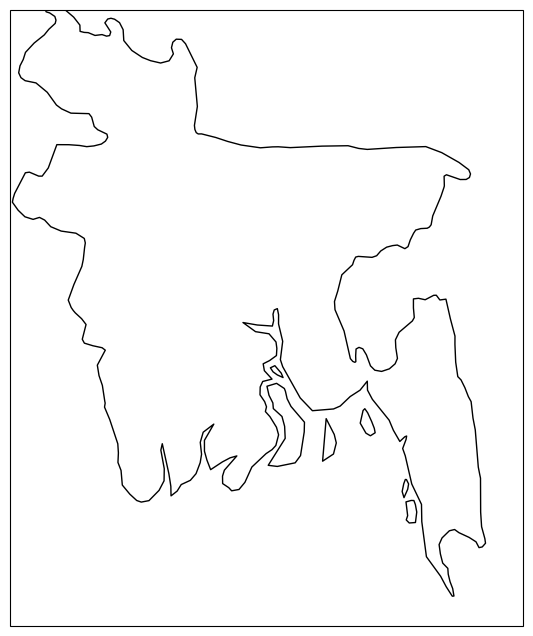

In [39]:

# Iterate over months (columns 6 to 17)
for month in range(7, 13):
    # Extract rainfall data for this month
    rainfall = df.iloc[:, 6 + month - 1]  # Column 6 corresponds to January, 7 to February, etc.
    
    # Perform Ordinary Kriging interpolation
    OK = OrdinaryKriging(df['lon_decimal'], df['lat_decimal'], rainfall, variogram_model='spherical', verbose=False, enable_plotting=False)
    
    # Execute Kriging on the grid
    grid_z_kriging, ss = OK.execute('grid', grid_x, grid_y)

    # Mask values outside Bangladesh
    #mask = np.array([Point(lon, lat).within(bangladesh_polygon) for lon, lat in zip(grid_x.flatten(), grid_y.flatten())])
    #grid_z_kriging = grid_z_kriging.data.reshape(grid_x.shape)
    #grid_z_kriging[~mask.reshape(grid_x.shape)] = np.nan

    # Plot the contour map for each month
    fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_extent([lon_min, lon_max, lat_min, lat_max])

    # Add Bangladesh border
    ax.add_geometries(bangladesh_shp.geometry, ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1)

    # Contour plot with custom colormap and normalized color map
    contour = ax.contourf(grid_x, grid_y, grid_z_kriging, levels=20, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())

    # Add color bar
    plt.colorbar(contour, ax=ax, orientation='vertical', label="Rainfall (mm)")

    # Add station points
    ax.scatter(df['lon_decimal'], df['lat_decimal'], c='black', marker='o', edgecolors='white', label="Stations")

    # Add features for better map context
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle='dotted')

    # Labels
    ax.set_title(f"Rainfall Trend Contour Map - Bangladesh - {month} Month")
    ax.legend()

    # Save or show the figure
    plt.show()
    # Alternatively, you can save the figure with a specific filename
    # fig.savefig(f"rainfall_map_month_{month}.png")
